<a href="https://colab.research.google.com/github/lucabarattini/transformer-is-all-you-need/blob/main/Luca_Barattini_LB3656_Applied_Machine_Learning_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMSW4995 - Applied Machine Learning - HW3:
### Luca Barattini - @lb3656:


---


## Data Preparation:  


---


##Importing our libraries:


In [1]:
### Importing libraries ###
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import torch


### Setting random seed ###
torch.manual_seed(0)

### Loading raw text ###
text_path = "input.txt"
with open(text_path, "r", encoding="utf-8") as f:
    text = f.read()


In [2]:
### Training the tokenizer ###
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(vocab_size=500, special_tokens=["[PAD]", "[UNK]"])
tokenizer.train_from_iterator([text], trainer=trainer)

### Encoding text to tensors ###
encoded = tokenizer.encode(text)
ids = torch.tensor(encoded.ids, dtype=torch.long)

### Preparing inputs and targets ###
seq_len = 50
num_sequences = len(ids) - seq_len
inputs = torch.stack([ids[i:i+seq_len] for i in range(num_sequences)])
targets = torch.stack([ids[i+1:i+seq_len+1] for i in range(num_sequences)])

### Splitting train and validation sets ###
split_idx = int(0.8 * len(inputs))
train_inputs = inputs[:split_idx]
val_inputs = inputs[split_idx:]
train_targets = targets[:split_idx]
val_targets = targets[split_idx:]

### Defining the Dataset class ###
class ShakespeareDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### Creating dataset instances ###
train_dataset = ShakespeareDataset(train_inputs, train_targets)
val_dataset = ShakespeareDataset(val_inputs, val_targets)

### Defining embedding layers ###
vocab_size = tokenizer.get_vocab_size()
d_model = 128
token_embedding = torch.nn.Embedding(vocab_size, d_model)

max_len = seq_len
pos_embedding = torch.nn.Embedding(max_len, d_model)

### Embedding function ###
def embed_tokens(x):
    positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)
    return token_embedding(x) + pos_embedding(positions)

## Implementing our Tiny-Transformer:


---

### Setup:

In [3]:
### Setting the device ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Creating DataLoaders ###
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)



---


### Model Architecture Definition:

In [4]:
### Defining a custom normalization layer ###
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        norm = x.pow(2).mean(-1, keepdim=True)
        return x * torch.rsqrt(norm + self.eps) * self.weight

### Defining the Transformer Block ###
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, seq_len):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
        )
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        self.register_buffer("causal_mask", mask)

    def forward(self, x, return_attn=False):
        seq_len = x.size(1)
        causal_mask = self.causal_mask[:seq_len, :seq_len]
        h = self.norm1(x)
        attn_out, attn_weights = self.attn(
            h, h, h,
            attn_mask=causal_mask,
            need_weights=True,
            average_attn_weights=False,
        )
        x = x + attn_out
        h = self.norm2(x)
        ff_out = self.ff(h)
        x = x + ff_out
        if return_attn:
            return x, attn_weights
        return x, None

### Defining the full Transformer model ###
class TinyTransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, d_ff, max_seq_len, n_layers):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)

        # Creating fixed sinusoidal positional encodings
        pos = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer("pos_encoding", pe.unsqueeze(0))

        # Stacking the transformer blocks
        self.layers = nn.ModuleList(
            [TransformerBlock(d_model, n_heads, d_ff, max_seq_len) for _ in range(n_layers)]
        )
        self.norm = RMSNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False) # Final output layer

    def forward(self, x, return_attn=False):
        bsz, seq_len = x.size()

        # Embedding tokens and adding positions
        tok = self.token_embedding(x)
        pos = self.pos_encoding[:, :seq_len, :]
        h = tok + pos

        # Passing through all layers
        attn_maps = []
        for layer in self.layers:
            h, attn = layer(h, return_attn=return_attn)
            if return_attn:
                attn_maps.append(attn)

        h = self.norm(h)
        logits = self.head(h) # Getting final word predictions

        if return_attn:
            return logits, attn_maps
        return logits



---


### Training, initialization and  Validation:

In [5]:
### Model initialization ###
d_model = 128
n_heads = 4
d_ff = 256
n_layers = 2

model = TinyTransformerLM(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    max_seq_len=seq_len,
    n_layers=n_layers,
).to(device)

### Setting up loss and optimizer ###
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

### Training loop setup ###
num_epochs = 5
train_losses = []
val_losses = []
val_ppls = []

### Main training loop ###
for epoch in range(1, num_epochs + 1):

    ### Training phase ###
    model.train() # Set model to training mode
    total_train_loss = 0.0
    total_tokens = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * x.numel()
        total_tokens += x.numel()

    avg_train_loss = total_train_loss / total_tokens
    train_losses.append(avg_train_loss)

    ### Validation phase ###
    model.eval() # Set model to evaluation mode
    total_val_loss = 0.0
    total_val_tokens = 0

    with torch.no_grad(): # Disable gradient calculation
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))

            total_val_loss += loss.item() * x.numel()
            total_val_tokens += x.numel()

    avg_val_loss = total_val_loss / total_val_tokens
    val_losses.append(avg_val_loss)
    val_ppl = math.exp(avg_val_loss) # Perplexity
    val_ppls.append(val_ppl)

    ### Printing results ###
    print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}, val_ppl={val_ppl:.2f}")

Epoch 1: train_loss=3.1742, val_loss=4.3565, val_ppl=77.98
Epoch 2: train_loss=2.6408, val_loss=4.7042, val_ppl=110.41
Epoch 3: train_loss=2.4772, val_loss=4.9589, val_ppl=142.44
Epoch 4: train_loss=2.3821, val_loss=5.1622, val_ppl=174.55
Epoch 5: train_loss=2.3193, val_loss=5.3281, val_ppl=206.05




---

## Plotting Training and Validation loss:

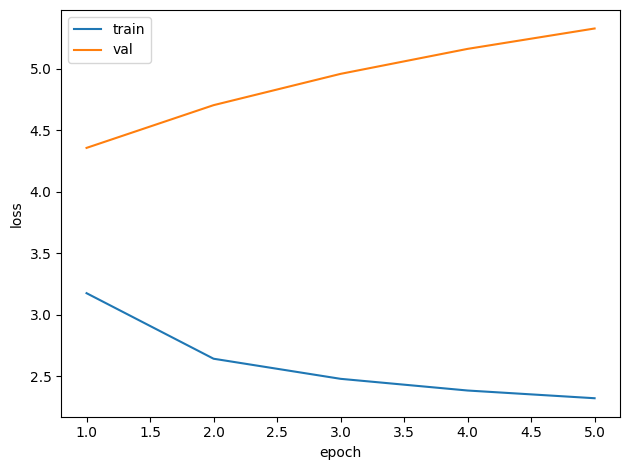

In [6]:
### Plotting the loss curves ###
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, label="train")
plt.plot(epochs, val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
### Printing final performance metrics ###
final_val_ppl = val_ppls[-1]
best_epoch = min(range(len(val_ppls)), key=lambda i: val_ppls[i]) + 1
best_val_ppl = val_ppls[best_epoch - 1]

print("Final Validation PPL:", final_val_ppl)
print("Best Epoch:", best_epoch, "best Validation PPL:", best_val_ppl)


NameError: name 'val_ppls' is not defined



---

### Attention Heatmap:

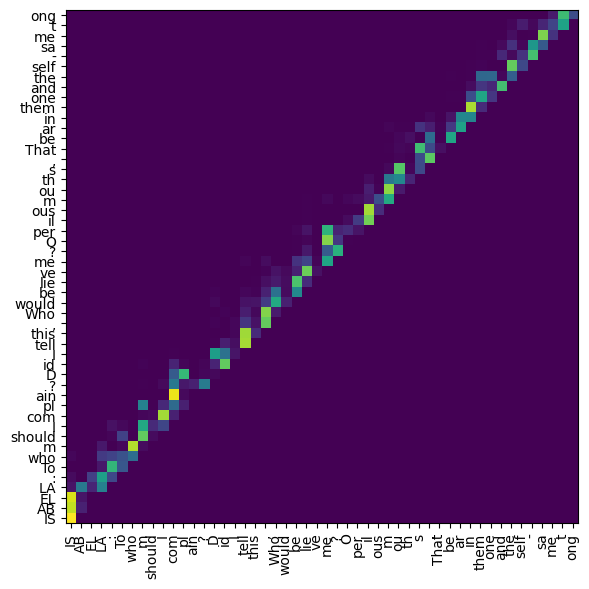

In [8]:
### Defining the attention heatmap function ###
def show_attention_heatmap(model, tokenizer, data_loader, device, layer=0, head=0):
    model.eval()
    with torch.no_grad():
        x, y = next(iter(data_loader))
        x = x[:1].to(device)

        logits, attn_maps = model(x, return_attn=True)

    attn = attn_maps[layer][0, head].cpu().numpy()

    ids = x[0].cpu().tolist()
    tokens = [tokenizer.id_to_token(i) for i in ids]
    #Plotting our heatmap:
    plt.figure(figsize=(6, 6))
    plt.imshow(attn, aspect="auto", origin="lower")
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.yticks(range(len(tokens)), tokens)
    plt.tight_layout()
    plt.show()
### Visualizing the heatmap ###
show_attention_heatmap(model, tokenizer, val_loader, device, layer=0, head=0)




---


### Text Generation (inference):

In [9]:
### Defining the text generation function ###
def generate_text(model, tokenizer, device, prompt, max_new_tokens=50):
    model.eval()
    with torch.no_grad():
      # We first prep the input prompt:
        encoded = tokenizer.encode(prompt)
        ids = torch.tensor(encoded.ids, dtype=torch.long, device=device).unsqueeze(0)
      # Loop through to generate one token at a time
        for _ in range(max_new_tokens):
            if ids.size(1) > seq_len:
                ids_cond = ids[:, -seq_len:]
            else:
                ids_cond = ids
            # We then get the model's predictions (logits)
            logits = model(ids_cond)
            # Convert them into probabilities
            next_token_logits = logits[0, -1]
            probs = torch.softmax(next_token_logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            ids = torch.cat([ids, next_id.unsqueeze(0)], dim=1)
        out_ids = ids[0].cpu().tolist()
        text = tokenizer.decode(out_ids)
    return text
### Generating and printing a sample ###
sample = generate_text(model, tokenizer, device, prompt="ROMEO:", max_new_tokens=80)
print(sample)


RO M E O : P y for c es the mar ve ll en e m i es again ? How ! that ' will not pre s end thee ? J O H N OF G A U N T : O n ce more , To g i ven his so . KING HEN RY V I : To y ard s er vi ce and re ign my c rown to me : this must in any spe st : Y
